In [1]:
import cv2
from pathlib import Path
from random import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(1000)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
data = pd.read_csv('fer2013.csv')

In [4]:
train_data = data[(data['Usage']== 'Training')].copy()
test_data = data[(data['Usage']=='PrivateTest') | (data['Usage']=='PublicTest')].copy()

In [5]:
train_data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
test_data.head(5)

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [7]:
num_classes = 7
epochs = 55
batch_size = 64
num_features = 32
width, height = 48,48

In [8]:
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = keras.utils.to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

In [9]:
train_images, train_labels = CRNO(train_data,'train')
test_images, test_labels = CRNO(test_data,'test')

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
test _X shape: {},  test _Y shape: (7178, 48, 48, 1)


In [10]:
from skimage.feature import hog
from imutils import face_utils
import dlib

In [11]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:/Users/Moh.Massoud/ML/shape_predictor_68_face_landmarks.dat")

In [12]:
def get_landmarks(img):
    rect = dlib.rectangle(0, 0, img.shape[0] - 1, img.shape[1] -1)
    img = img.astype(np.uint8)
    #gray = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2GRAY)
    #print(img.shape, type(img[0][0][0]))
    landmarks = predictor(img, rect)
    landmarks = face_utils.shape_to_np(landmarks)
    return landmarks

(28709, 48, 48, 1) <class 'numpy.float32'>


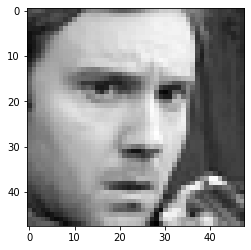

In [13]:
plt.imshow(train_images[0], plt.cm.gray)
print(train_images.shape, type(train_images[0][0][0][0]))

In [14]:
train_landmarks = np.asarray([get_landmarks(img) for img in train_images])
test_landmarks = np.asarray([get_landmarks(img) for img in test_images])

In [15]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=64, input_shape=(48,48,1), kernel_size=(3,3), activation='elu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.2),
    
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu'),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.2),
    
    #keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    #keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    #keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(272, activation='elu'),
    #keras.layers.Dropout(0.7),
    keras.layers.Dense(136, activation='elu'),
    #keras.layers.Dropout(0.7),
    keras.layers.Dense(68, activation='elu'),
    #keras.layers.Dropout(0.7),
    
    keras.layers.Dense(7, activation='softmax')
])

In [16]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(train_images, train_labels, epochs=7)

Train on 28709 samples
Epoch 1/7
28709/28709 [==============================] - 10s 339us/sample - loss: 1.6283 - accuracy: 0.3551
Epoch 2/7
28709/28709 [==============================] - 8s 286us/sample - loss: 1.3758 - accuracy: 0.4678
Epoch 3/7
28709/28709 [==============================] - 8s 287us/sample - loss: 1.2696 - accuracy: 0.5150
Epoch 4/7
28709/28709 [==============================] - 8s 289us/sample - loss: 1.1659 - accuracy: 0.5546
Epoch 5/7
28709/28709 [==============================] - 8s 277us/sample - loss: 1.0883 - accuracy: 0.5879
Epoch 6/7
28709/28709 [==============================] - 8s 272us/sample - loss: 0.9928 - accuracy: 0.6263
Epoch 7/7
28709/28709 [==============================] - 8s 275us/sample - loss: 0.9227 - accuracy: 0.6564


In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

7178/7178 - 1s - loss: 1.1781 - accuracy: 0.5729


In [19]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.gray)
  true_label = np.argmax(true_label)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(7), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


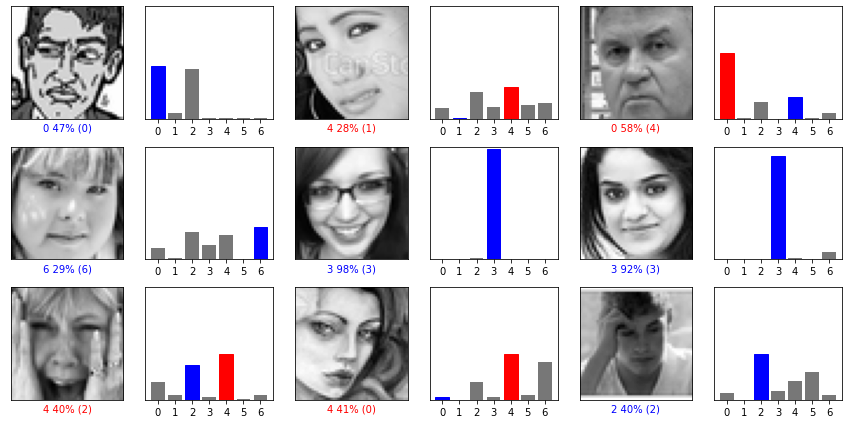

In [20]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
predictions = model.predict(test_images)
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()